# Noncontextual embeddings 

Notebook for Word2Vec Slovene language.

In [44]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [45]:
import nltk

In [71]:
TOP_N = 10
KEYS = { \
    "seksizem": set(), 
    "rasizem": set(), 
    "blatenje": set(), 
    "homofobija": set(), 
    #"sovražni_govor": set(), 
    "nadlegovanje": set(), 
    "žaljenje": set(), 
    "sovražnost": set(), 
    "vulgarnost": set(), 
    "bogokletnost": set(), 
    "nespodobnost": set(), 
    "nasilje": set(), 
    "benevolentnost": set(), 
    "diskreditiranje": set(), 
    "napadalnost": set(),
    "grožnja": set(),
    "toksičnost": set(),
    #"vsiljenost": set(),
    #"spletno nasilje": set(),        
}

FIXED_KEYS = list(KEYS.keys())

In [72]:
import lemmagen.lemmatizer
from lemmagen.lemmatizer import Lemmatizer

lemmatizer = Lemmatizer(dictionary=lemmagen.DICTIONARY_SLOVENE)

from slovene_stemmer import stem


In [73]:
#lemmatizer = WordNetLemmatizer() 
#ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    #stem = ps.stem(key)
    st = stem([key])
    print(st)
    KEYS[key].add(lemma)
    KEYS[key].add(st[0])
    KEYS[key].add(key)
KEYS

['seksiz']
['rasiz']
['blaten']
['homofob']
['nadleg']
['žaljen']
['sovraž']
['vulgar']
['bogoklet']
['nespodob']
['nasil']
['benev']
['diskredit']
['napad']
['grožn']
['toksič']


{'seksizem': {'seksiz', 'seksizem'},
 'rasizem': {'rasiz', 'rasizem'},
 'blatenje': {'blaten', 'blatenje'},
 'homofobija': {'homofob', 'homofobija'},
 'nadlegovanje': {'nadleg', 'nadlegovanje'},
 'žaljenje': {'žaljen', 'žaljenje'},
 'sovražnost': {'sovraž', 'sovražnost'},
 'vulgarnost': {'vulgar', 'vulgarnost'},
 'bogokletnost': {'bogoklet', 'bogokletnost'},
 'nespodobnost': {'nespodob', 'nespodobnost'},
 'nasilje': {'nasil', 'nasilje'},
 'benevolentnost': {'benev', 'benevolentnost'},
 'diskreditiranje': {'diskredit', 'diskreditiranje'},
 'napadalnost': {'napad', 'napadalnost'},
 'grožnja': {'grožn', 'grožnja'},
 'toksičnost': {'toksič', 'toksičnost'}}

In [74]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [75]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [76]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [77]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [78]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [79]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [80]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [81]:
def plot_similar_words3d(title, labels, embedding_clusters, word_clusters, filename=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        z = embeddings[:, 2]
        ax.scatter(x, y,z, c=color, alpha=0.7, label=label)
        #for i, word in enumerate(words):              
            #plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
            #             textcoords='offset points', ha='right', va='bottom', size=8)
        #    plt.text(x,y,z, word, alpha=0.5,
        #                 textcoords='offset points', ha='right', va='bottom', size=8)
        #    ax.text(x,y,z, word, alpha=1.0,
        #        textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [14]:
def plotMDS3D(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_3d = MDS(n_components=3, max_iter=3500, random_state=32)
    model_en_3d = model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_3d = np.array(model_en_3d).reshape(n, m, 3)
    plot_similar_words3d(title, FIXED_KEYS, embeddings_en_3d, word_clusters, filename)

In [82]:
#model_gn = gensim.downloader.load('word2vec-google-news-300')
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("models/model.bin", binary = True)

In [83]:
word_clusters_a, embedding_clusters = getSimilarWords(model)

{'seksizem', 'seksiz'} -- seksizma
{'homofobija', 'homofob'} -- homofobijo
{'nadleg', 'nadlegovanje'} -- nadlegovanja
{'sovražnost', 'sovraž'} -- sovražnosti
{'nasilje', 'nasil'} -- nasilja
{'nasilje', 'nasil'} -- nasiljem
{'nasilje', 'nasil'} -- nasilju
{'nasilje', 'nasil'} -- nasilno
{'grožnja', 'grožn'} -- grožnje
{'grožnja', 'grožn'} -- grožnjo
{'toksič', 'toksičnost'} -- toksična


In [84]:
displayDF(word_clusters_a)

,seksizem,rasizem,blatenje,homofobija,nadlegovanje,žaljenje,sovražnost,vulgarnost,bogokletnost,nespodobnost,nasilje,benevolentnost,diskreditiranje,napadalnost,grožnja,toksičnost
0,benevolenten,partnerjazenske,žalitev,ksenofobija,nasilje,kritiziranje,sumničavost,samovšečnost,metnih,tankočuten,nadlegovanje,nepartnerskega,administrirajo,nasilnost,izkoriščevalska,strupenost
1,šovinizem,partnerjastrani,žaljenje,seksizem,šikaniranje,zaljenje,nezaupanje,prevarantstvo,požigalcev,metafikcijska,medvrstniško,nenačelna,asocialnih,agresivnost,naperjena,biorazpoložljivost
2,mazohizem,ksenofobija,zmerjanje,seksizma,ustrahovanje,zasmehovanje,brezobzirnost,otroškost,fallacijeva,obsesivnost,posilstvo,demosovih,servilnosti,pritlikavost,nevarnost,mutagenost
3,ksenofobija,homoseksualnost,licemerstvo,homoseksualcev,posilstvo,blatenje,sovraštvo,banalnost,terjanja,govorčevo,intimnopartnersko,prostest,nacizme,prepirljivost,uperjena,desetilatrazin
4,feminizem,terorizem,navzdolne,feminizem,trpinčenje,zmerjanje,prepirljivost,kategoričnega,prijetimi,avtoreferenčno,delikt,novonastajajoča,sramotitev,brezupnost,sprevržena,bazičnost
5,homofobija,šovinizem,kritiziranje,šovinizem,poniževanje,primitivnost,zagrenjenosti,tragičnost,razselitev,rahločuten,homofobijo,aferaštva,anarhične,nevrotičnost,nespametna,rezistenca
6,antisocialno,narkomanija,natolcevanje,homoseksualnost,diskriminacijo,poniževanje,napadalnost,smešnost,čudaštev,erotizirana,sovraštvo,kanclerkine,sre~nih,nepotrpežljivost,neizbežna,farmakokinetične
7,nekrofilija,konsenzualne,norčevanje,muslimank,nemoralno,žaljivega,brezupnost,nihilistična,srečnejših,razumljivostjo,poniževanje,protidemokratičen,perpetuiranje,sovražnost,pretila,steviozid
8,socializirano,neonacizem,krsenje,kuffar,pretepanje,žalitev,prestopništvo,ranjenosti,hiltonovo,liričnost,stigmatizacije,premetenca,cincanje,prestrašenost,gonja,gastrointestinalnih
9,nasilje,pedofilija,demonizacijo,sadizem,kaznivo,namigovanje,agresivnost,škodoželjnost,maščevano,digresijo,nestrpnost,obstrukcij,_dejansko_,sumničavost,pomisel,karcinogen


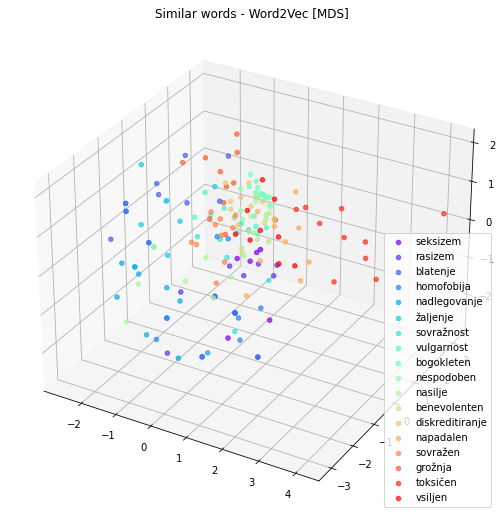

In [18]:

plotMDS3D("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS_3d.png")

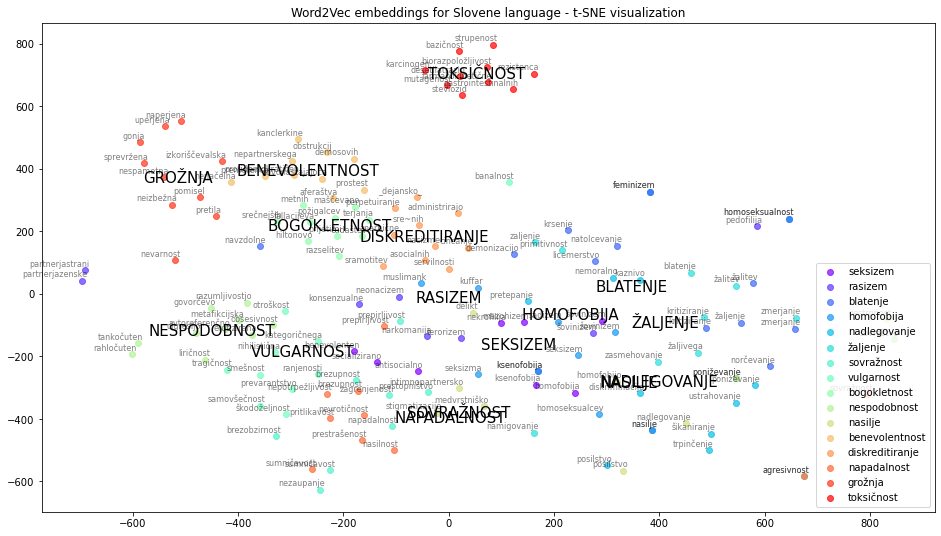

In [85]:
plotTSNE("Word2Vec embeddings for Slovene language - t-SNE visualization", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - t-SNE_1 - Slovene.png")

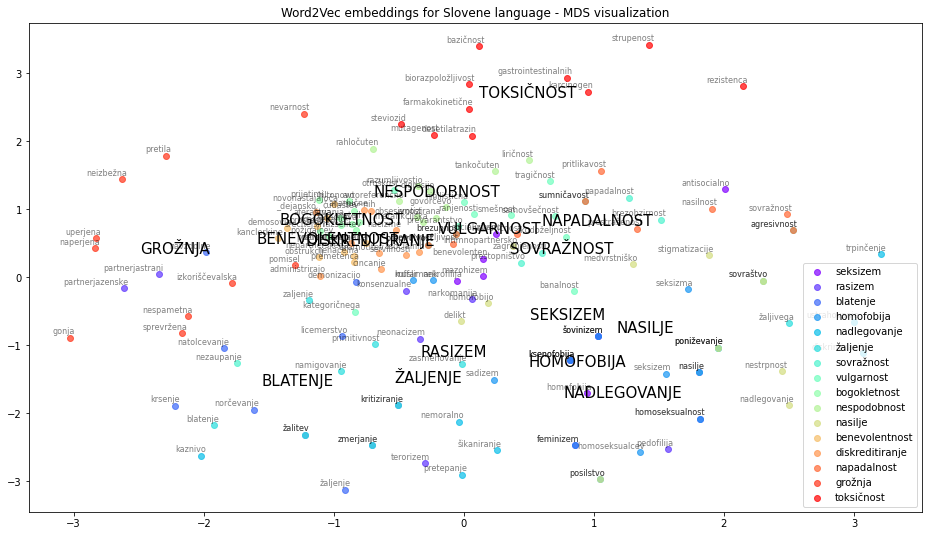

In [86]:
plotMDS("Word2Vec embeddings for Slovene language - MDS visualization", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS_1 - Slovene.png")

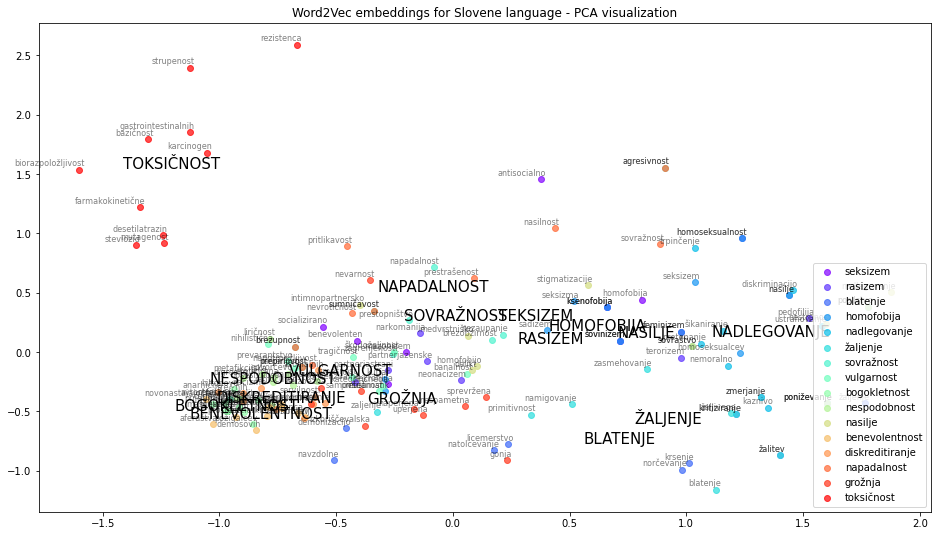

In [87]:
plotPCA("Word2Vec embeddings for Slovene language - PCA visualization", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - PCA_1 - Slovene.png")

## Clustering

Compute average vectors from the embedding words

In [22]:
avg_embeddings = dict()
for i, key in enumerate(FIXED_KEYS):
    avg_embeddings[key]= np.mean(np.array(embedding_clusters[i]), axis = 0)

### KMean

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
dist_matrix = 1 - cosine_similarity(list(avg_embeddings.values()))

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_clusters = list(range(2,10))
avg = []
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(dist_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(dist_matrix, clusters)
    avg.append(silhouette_avg)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

2 clusters - silhouette: 0.6062533855438232
3 clusters - silhouette: 0.32397884130477905
4 clusters - silhouette: 0.30158963799476624
5 clusters - silhouette: 0.30396631360054016
6 clusters - silhouette: 0.30856630206108093
7 clusters - silhouette: 0.2430488020181656
8 clusters - silhouette: 0.27719932794570923
9 clusters - silhouette: 0.2198239415884018


Text(0, 0.5, 'silhouette score')

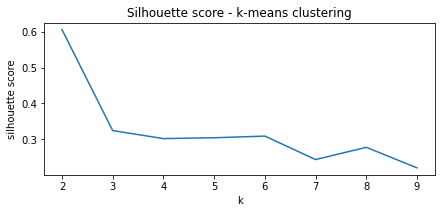

In [25]:
plt.figure(figsize=(7, 2.8))
plt.plot(range_clusters, avg)
plt.title("Silhouette score - k-means clustering")
plt.xlabel("k")
plt.ylabel("silhouette score")

In [26]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(dist_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

Wall time: 87.7 ms
Clusters: [3, 3, 0, 3, 6, 0, 3, 4, 1, 1, 6, 4, 4, 1, 4, 5, 2, 1]


In [27]:
for i in range(num_clusters):
    print(f"Cluster {i}: {np.array(FIXED_KEYS)[np.where(i == np.array(clusters))[0]]}")

Cluster 0: ['blatenje' 'žaljenje']
Cluster 1: ['bogokleten' 'nespodoben' 'napadalen' 'vsiljen']
Cluster 2: ['toksičen']
Cluster 3: ['seksizem' 'rasizem' 'homofobija' 'sovražnost']
Cluster 4: ['vulgarnost' 'benevolenten' 'diskreditiranje' 'sovražen']
Cluster 5: ['grožnja']
Cluster 6: ['nadlegovanje' 'nasilje']


### Hierarhical clustering

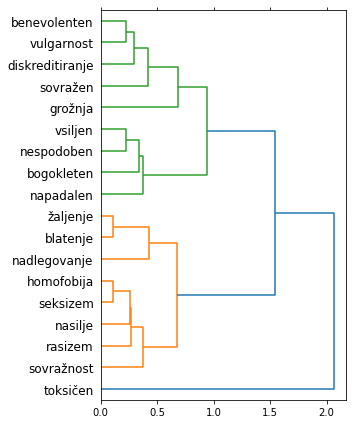

In [28]:
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist_matrix) 

fig, ax = plt.subplots(figsize=(5, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=FIXED_KEYS);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()

# fasttext

In [29]:
# Run first time only to download model
#import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')


In [88]:
model_gn = load_facebook_vectors("models/cc.sl.300.bin.gz")

In [103]:
TOP_N = 20
KEYS = { \
    "seksizem": set(), 
    "rasizem": set(), 
    "blatenje": set(), 
    "homofobija": set(), 
    #"sovražni_govor": set(), 
    "nadlegovanje": set(), 
    "žaljenje": set(), 
    "sovražnost": set(), 
    "vulgarnost": set(), 
    "bogokletnost": set(), 
    "nespodobnost": set(), 
    "nasilje": set(), 
    "benevolentnost": set(), 
    "diskreditiranje": set(), 
    "napadalnost": set(),
    "grožnja": set(),
   # "toksičnost": set(),
    "vsiljenost": set(),
    #"spletno nasilje": set(),        
}


FIXED_KEYS = list(KEYS.keys())

In [104]:
import lemmagen.lemmatizer
from lemmagen.lemmatizer import Lemmatizer

lemmatizer = Lemmatizer(dictionary=lemmagen.DICTIONARY_SLOVENE)

from slovene_stemmer import stem

In [105]:
#lemmatizer = WordNetLemmatizer() 
#ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    #stem = ps.stem(key)
    st = stem([key])
    print(st)
    KEYS[key].add(lemma)
    KEYS[key].add(st[0])
    KEYS[key].add(key)
KEYS

['seksiz']
['rasiz']
['blaten']
['homofob']
['nadleg']
['žaljen']
['sovraž']
['vulgar']
['bogoklet']
['nespodob']
['nasil']
['benev']
['diskredit']
['napad']
['grožn']
['vsilj']


{'seksizem': {'seksiz', 'seksizem'},
 'rasizem': {'rasiz', 'rasizem'},
 'blatenje': {'blaten', 'blatenje'},
 'homofobija': {'homofob', 'homofobija'},
 'nadlegovanje': {'nadleg', 'nadlegovanje'},
 'žaljenje': {'žaljen', 'žaljenje'},
 'sovražnost': {'sovraž', 'sovražnost'},
 'vulgarnost': {'vulgar', 'vulgarnost'},
 'bogokletnost': {'bogoklet', 'bogokletnost'},
 'nespodobnost': {'nespodob', 'nespodobnost'},
 'nasilje': {'nasil', 'nasilje'},
 'benevolentnost': {'benev', 'benevolentnost'},
 'diskreditiranje': {'diskredit', 'diskreditiranje'},
 'napadalnost': {'napad', 'napadalnost'},
 'grožnja': {'grožn', 'grožnja'},
 'vsiljenost': {'vsilj', 'vsiljenost'}}

In [106]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)
word_clusters

{'seksizem', 'seksiz'} -- seksizem
{'seksizem', 'seksiz'} -- cisseksizem
{'seksizem', 'seksiz'} -- heteroseksizem
{'seksizem', 'seksiz'} -- seksizmu
{'seksizem', 'seksiz'} -- heteroseksizem
{'seksizem', 'seksiz'} -- seksizma
{'rasizem', 'rasiz'} -- rasizem
{'rasizem', 'rasiz'} -- rasizma
{'rasizem', 'rasiz'} -- rasizmu
{'blatenje', 'blaten'} -- blatenje
{'blatenje', 'blaten'} -- blatenjem
{'blatenje', 'blaten'} -- blatenja
{'blatenje', 'blaten'} -- blatenju
{'homofobija', 'homofob'} -- homofobija
{'homofobija', 'homofob'} -- homofobi
{'homofobija', 'homofob'} -- homofobije
{'homofobija', 'homofob'} -- homofobijo
{'nadleg', 'nadlegovanje'} -- nadlegovanje
{'nadleg', 'nadlegovanje'} -- nadlegovanja
{'nadleg', 'nadlegovanje'} -- nadlegovane
{'nadleg', 'nadlegovanje'} -- nadlegovanju
{'nadleg', 'nadlegovanje'} -- nadlegovani
{'nadleg', 'nadlegovanje'} -- nadlegovano
{'nadleg', 'nadlegovanje'} -- nadlegovana
{'nadleg', 'nadlegovanje'} -- nadlegovanega
{'nadleg', 'nadlegovanje'} -- nadlegova

[['Bruksizem',
  'Rasizem',
  'bruksizem',
  'fasizem',
  'mačizem',
  'seksualizem',
  'Sizeizem',
  'rasizem',
  'krausizem',
  'fetišizem',
  'solipsizem',
  'sizeizem',
  'specisizem',
  'Reizem',
  'Sadizem',
  'bahaizem',
  'seksistični',
  'izem',
  'slengizem',
  'panpsihizem'],
 ['fasizem',
  'Bruksizem',
  'krausizem',
  'bruksizem',
  'seksizem',
  'izem',
  'Tačizem',
  'Seksizem',
  'snobizem',
  'Sizeizem',
  'amygizem',
  'mohizem',
  'pučizem',
  'tahizem',
  'panpsihizem',
  'mazohizem',
  'evfuizem',
  'atavizem',
  'Reizem',
  'ramizem'],
 ['klatenje',
  'platenje',
  'mlatenje',
  'zlatenje',
  'Ihtenje',
  'tenje',
  'ihtenje',
  'Drhtenje',
  'črtenje',
  'Zlatenje',
  'Genje',
  'kratenje',
  'netenje',
  'vpraĹĄanje',
  'Slutenje',
  'Netenje',
  'bohotenje',
  'Obzhutenje',
  'gomazenje',
  'bentenje'],
 ['fazmofobija',
  'dromofobija',
  'ginofobija',
  'Kromofobija',
  'Bifobija',
  'Kemofobija',
  'lalofobija',
  'tafofobija',
  'zoofobija',
  'osmofobija',


In [107]:
displayDF(word_clusters)


,seksizem,rasizem,blatenje,homofobija,nadlegovanje,žaljenje,sovražnost,vulgarnost,bogokletnost,nespodobnost,nasilje,benevolentnost,diskreditiranje,napadalnost,grožnja,vsiljenost
0,Bruksizem,fasizem,klatenje,fazmofobija,Ustrahovanje,šaljenje,Vzdražnost,arnost,nedoletnost,spodobnost,zlorabljanje,Ekvipolentnost,akreditiranje,alnost,Požnja,oddáljenost
1,Rasizem,Bruksizem,platenje,dromofobija,ustrahovanje,žvaljenje,lažnost,Imúnost,etnost,bogopodobnost,Ustrahovanje,ekvipolentnost,mikrokreditiranje,udarnost,voĹžnja,izpiljenost
2,bruksizem,krausizem,mlatenje,ginofobija,šikaniranje,hvaljenje,vzdražnost,političnost,nadumetnost,Spodobnost,ustrahovanje,somnolentnost,kreditiranje,razdiralnost,grožja,Ožiljenost
3,fasizem,bruksizem,zlatenje,Kromofobija,nasilje,samohvaljenje,Važnost,bizarnost,Akútnost,zadobnost,nadlegovanje,fluentnost,Kreditiranje,tekmavalnost,Mržnja,prisiljenost
4,mačizem,seksizem,Ihtenje,Bifobija,drogiranje,razgaljenje,užaljenost,Psévdoznánost,koketnost,spodobnostjo,posiljevanje,Dlinkventnost,agitiranje,uničevalnost,-nevarnost,vseenost
5,seksualizem,izem,tenje,Kemofobija,Trpinčenje,Škíljenje,žnost,družbenost,konkretnost,prav-nost,Izsiljevanje,valentnost,bonitiranje,kalnost,ekovožnja,ukrívljenost
6,Sizeizem,Tačizem,ihtenje,lalofobija,zalezovanje,mazíljenje,moĹžnost,zoprnost,strahopetnost,brezsramnost,vsiljevanje,lasntnost,asisitiranje,socialnost,Jahalomin,Precépljenost
7,rasizem,Seksizem,Drhtenje,tafofobija,posiljevanje,AWB-janje,Vlážnost,Slánost,nespametnost,lenobnost,silje,Agentnost,Citiranje,strupénost,nevarnost,zaksrbljenost
8,krausizem,snobizem,črtenje,zoofobija,diskriminiranje,buljenje,Kúžnost,brezléčnost,ANSI-umetnost,neudobnost,izsiljevanje,delikventnost,samocitiranje,bipedalnost,"2,2-13",izrabljenost
9,fetišizem,Sizeizem,Zlatenje,osmofobija,psovanje,naalkaljenje,konfliktnost,prav-nost,Spametnost,hudobnost,zlorabljeno,surgentnost,meditiranje,lnost,bojazen,jesamodjenost


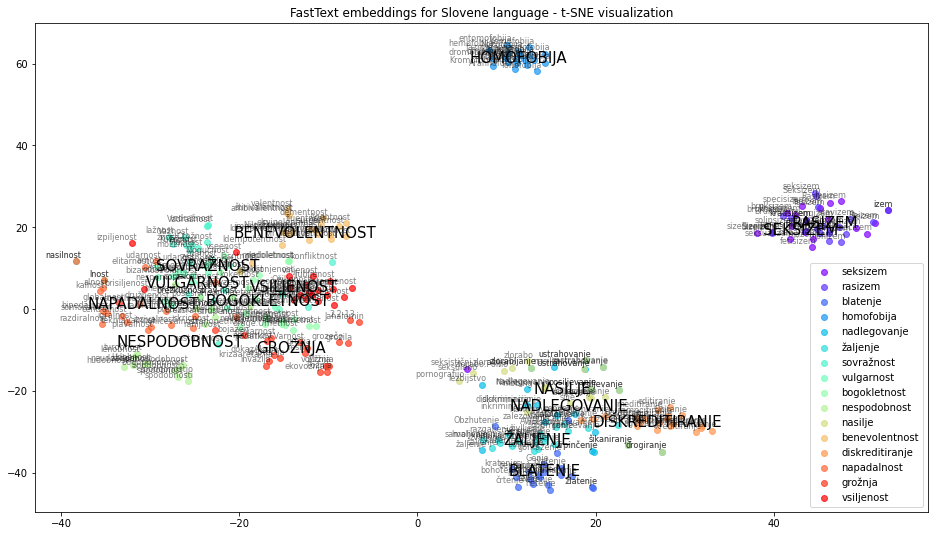

In [108]:
plotTSNE("FastText embeddings for Slovene language - t-SNE visualization", word_clusters, embedding_clusters, "SimilarWords - fastText - t-SNE_1 - Slovene.png")


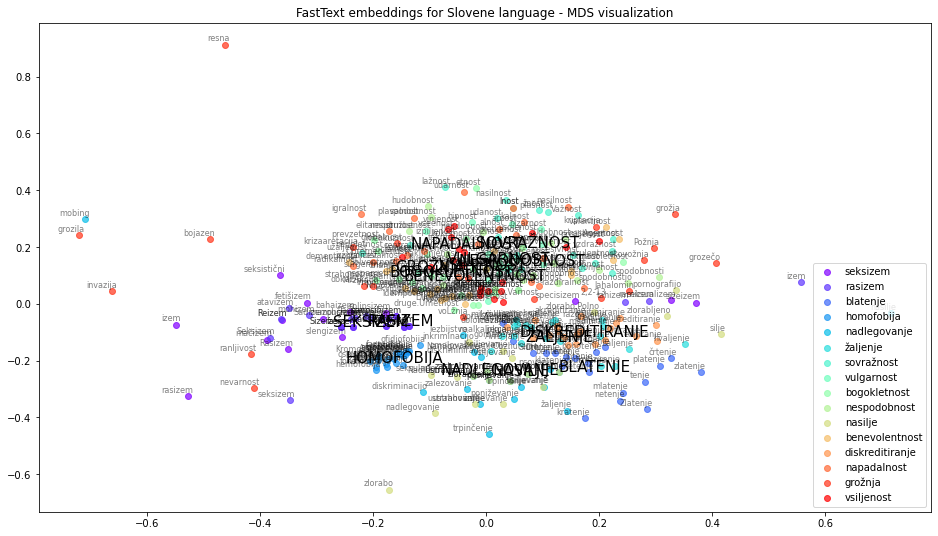

In [109]:
plotMDS("FastText embeddings for Slovene language - MDS visualization", word_clusters, embedding_clusters, "SimilarWords - fastText - MDS - Slovene.png")


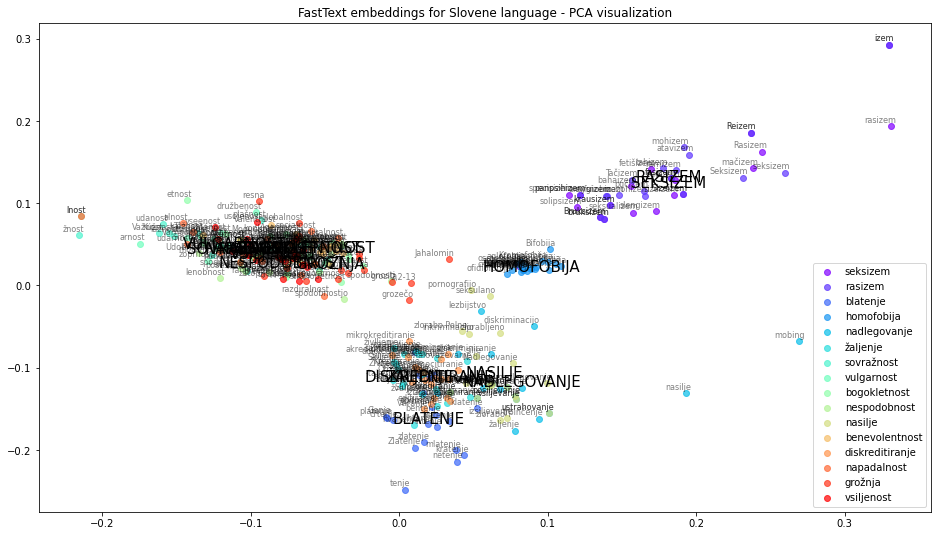

In [110]:
plotPCA("FastText embeddings for Slovene language - PCA visualization", word_clusters, embedding_clusters, "SimilarWords - fastText - PCA - Slovene.png")


## Clustering

In [39]:
avg_embeddings = dict()
for i, key in enumerate(FIXED_KEYS):
    avg_embeddings[key]= np.mean(np.array(embedding_clusters[i]), axis = 0)

### Kmeans

In [40]:
dist_matrix = 1 - cosine_similarity(list(avg_embeddings.values()))
range_clusters = list(range(2,15))
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(dist_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(dist_matrix, clusters)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

2 clusters - silhouette: 0.3816504180431366
3 clusters - silhouette: 0.3877662718296051
4 clusters - silhouette: 0.42452603578567505
5 clusters - silhouette: 0.3438163101673126
6 clusters - silhouette: 0.3341917097568512
7 clusters - silhouette: 0.3477233350276947
8 clusters - silhouette: 0.34353458881378174
9 clusters - silhouette: 0.3391488492488861
10 clusters - silhouette: 0.283881813287735
11 clusters - silhouette: 0.262967050075531
12 clusters - silhouette: 0.23182351887226105
13 clusters - silhouette: 0.20663480460643768
14 clusters - silhouette: 0.11695348471403122


In [41]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(dist_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

Wall time: 23.5 ms
Clusters: [0, 0, 3, 0, 3, 2, 2, 1, 1, 3, 1, 3, 1, 2, 1]


In [42]:
for i in range(num_clusters):
    print(f"Cluster {i}: {np.array(FIXED_KEYS)[np.where(i == np.array(clusters))[0]]}")

Cluster 0: ['seksizem' 'rasizem' 'homofobija']
Cluster 1: ['bogokleten' 'nespodoben' 'benevolenten' 'napadalen' 'vsiljen']
Cluster 2: ['sovražnost' 'vulgarnost' 'grožnja']
Cluster 3: ['blatenje' 'žaljenje' 'nasilje' 'diskreditiranje']


### Hierarchical clustering

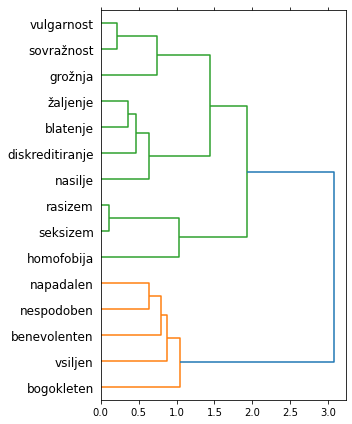

In [43]:
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist_matrix) 

fig, ax = plt.subplots(figsize=(5, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=FIXED_KEYS);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()